In [2]:
import itertools
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import nltk
from collections import Counter
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

%matplotlib inline

In [3]:
#importing the dataset
amazon = pd.read_csv('AmazonDataChunk1.csv', encoding = "ISO-8859-1")
amazon.head()

,productId,userId,profileName,helpfulness,score,time,summary,text
0,B003AI2VGA,A141HP4LYPWMSR,Brian E. Erland Rainbow Sphinx,7-Jul,3.0,1182729600,There Is So Much Darkness Now ~ Come For The M...,Synopsis On the daily trek from Juarez Mexico ...
1,B003AI2VGA,A328S9RN3U5M68,Grady Harp,7/8,3.0,1181952000,Worthwhile and Important Story Hampered by Poo...,THE VIRGIN OF JUAREZ is based on true events s...
2,B003AI2VGA,A1I7QGUDP043DG,Chrissy K. McVay Writer,7/9,5.0,1164844800,This movie needed to be made.,The scenes in this film can be very disquietin...
3,B003AI2VGA,A1M5405JH9THP9,golgotha.gov,7/10,3.0,1197158400,distantly based on a real tragedy,THE VIRGIN OF JUAREZ (2006)<br />directed by K...
4,B003AI2VGA,ATXL536YX71TR,KerrLines &#34;MoviesMusicTheatre&#34;,7/11,3.0,1188345600,What's going on down in Juarez and shining a l...,Informationally this SHOWTIME original is esse...


In [4]:
amazon.tail()

,productId,userId,profileName,helpfulness,score,time,summary,text
249995,B001FFBI82,A3T0WOOIYXUXHD,Greg Lovitz,0/1,4.0,1150156800,Very Good and Decent !,Jarhead is isn't the best picture of 2005 an...
249996,B001FFBI82,A1Q15TP2FXYYMF,www.steveo2006.co.uk Steveo,0/1,5.0,1149811200,Possible Classic & Underrated,This highly underrated film will come to defin...
249997,B001FFBI82,A1F6989VCEFK3Y,amaris2004,0/1,4.0,1142294400,deep movie...,i really enjoyed this movie. im not one to wat...
249998,B001FFBI82,A3UPYGJKZ0XTU4,mirasreviews,8/14,4.0,1143244800,A Marine in Operation Desert Storm Chronic Ted...,Jarhead is based on Anthony Swofford's memoir...
249999,B001FFBI82,A1ZYV05OSO4QZK,Zulu Warrior 71RoadRunner,3/6,3.0,1144713600,Flawed but useful,1) Why does Kayne West song appear which was p...


In [5]:
#check missing values
amazon.isnull().sum()

productId        0
userId           0
profileName      7
helpfulness      2
score            2
time             0
summary          1
text           122
dtype: int64

In [6]:
# Remove null values
amazon = amazon.dropna()
amazon = amazon.reset_index(drop=True)

In [7]:
#Recheck missing values
amazon.isnull().sum()

productId      0
userId         0
profileName    0
helpfulness    0
score          0
time           0
summary        0
text           0
dtype: int64

In [8]:
amazon.tail()

,productId,userId,profileName,helpfulness,score,time,summary,text
249863,B001FFBI82,A3T0WOOIYXUXHD,Greg Lovitz,0/1,4.0,1150156800,Very Good and Decent !,Jarhead is isn't the best picture of 2005 an...
249864,B001FFBI82,A1Q15TP2FXYYMF,www.steveo2006.co.uk Steveo,0/1,5.0,1149811200,Possible Classic & Underrated,This highly underrated film will come to defin...
249865,B001FFBI82,A1F6989VCEFK3Y,amaris2004,0/1,4.0,1142294400,deep movie...,i really enjoyed this movie. im not one to wat...
249866,B001FFBI82,A3UPYGJKZ0XTU4,mirasreviews,8/14,4.0,1143244800,A Marine in Operation Desert Storm Chronic Ted...,Jarhead is based on Anthony Swofford's memoir...
249867,B001FFBI82,A1ZYV05OSO4QZK,Zulu Warrior 71RoadRunner,3/6,3.0,1144713600,Flawed but useful,1) Why does Kayne West song appear which was p...


In [9]:
print('Dataset size: {:,} words'.format(len(amazon)))

Dataset size: 249,868 words


In [10]:
#Number of Reviews by Unique Products [productId]
movies = amazon['score'].groupby(amazon['productId']).count()
print("Number of Unique Products in amazon reviews = {}".format(movies.count()))

Number of Unique Products in amazon reviews = 7684


Text(0.5,1,'Top 5 Reviewed Movies')

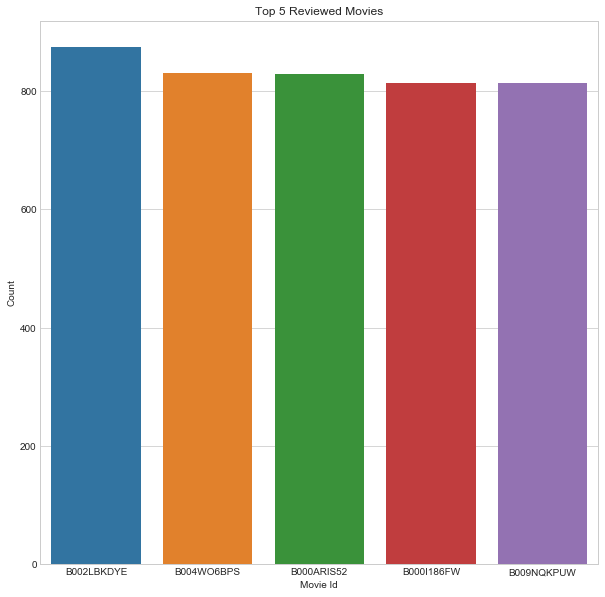

In [11]:
import seaborn as sns
top_movies=amazon.groupby(by=['productId'],as_index=False).count().sort_values(by='score',ascending=False).head()

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x=top_movies['productId'],y=top_movies['score'])
plt.xlabel("Movie Id")
plt.ylabel("Count")
plt.title("Top 5 Reviewed Movies")

Text(0.5,1,'Worst 5 Reviewed Movies')

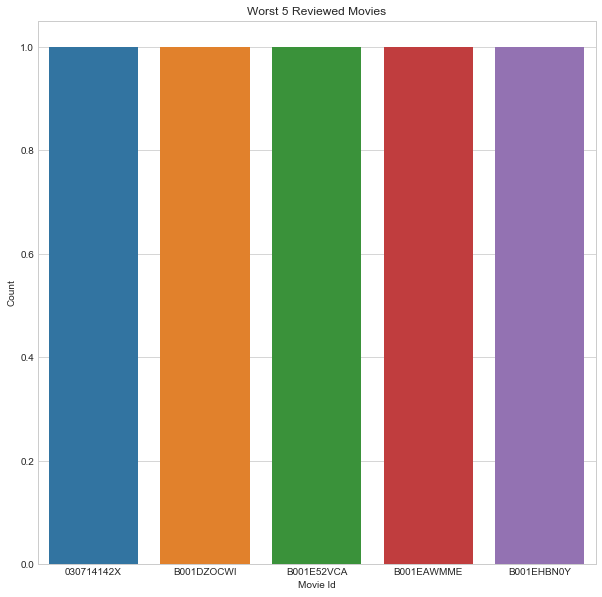

In [12]:
import seaborn as sns
worst_movies=amazon.groupby(by=['productId'],as_index=False).count().sort_values(by='score',ascending=True).head()

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x=worst_movies['productId'],y=worst_movies['score'])
plt.xlabel("Movie Id")
plt.ylabel("Count")
plt.title("Worst 5 Reviewed Movies")

In [13]:
#Preprocessing:
#Remove punctuations, stopwords, and lemmatize
amazon['text'][:11]

0     Synopsis On the daily trek from Juarez Mexico ...
1     THE VIRGIN OF JUAREZ is based on true events s...
2     The scenes in this film can be very disquietin...
3     THE VIRGIN OF JUAREZ (2006)<br />directed by K...
4     Informationally this SHOWTIME original is esse...
5     The murders in Juarez are real. This movie is ...
6     Mexican men are macho rapists gangsters or ine...
7     Over the past few years public television has ...
8     I recvd this video (DVD version) as a Christma...
9     Wow! When I saw this show on PBS--that was it ...
10    I have the Doo Wop 50 and 51 DVDs and was anxi...
Name: text, dtype: object

In [20]:
reviews = amazon['text']

In [21]:
reviews.count()

249868

In [22]:
stops = stopwords.words('english')

In [23]:
def tokenize(text):
    tokenized = word_tokenize(text)
    no_punc = []
    for review in tokenized:
        line = "".join(char for char in review if char not in string.punctuation)
        no_punc.append(line)
    tokens = lemmatize(no_punc)
    return tokens


def lemmatize(tokens):
    lmtzr = WordNetLemmatizer()
    lemma = [lmtzr.lemmatize(t) for t in tokens]
    return lemma

In [24]:
reviews = reviews.apply(lambda x: tokenize(x))

In [25]:
reviews[:11]

0     [Synopsis, On, the, daily, trek, from, Juarez,...
1     [THE, VIRGIN, OF, JUAREZ, is, based, on, true,...
2     [The, scene, in, this, film, can, be, very, di...
3     [THE, VIRGIN, OF, JUAREZ, , 2006, , , br, , , ...
4     [Informationally, this, SHOWTIME, original, is...
5     [The, murder, in, Juarez, are, real, , This, m...
6     [Mexican, men, are, macho, rapist, gangster, o...
7     [Over, the, past, few, year, public, televisio...
8     [I, recvd, this, video, , DVD, version, , a, a...
9     [Wow, , When, I, saw, this, show, on, PBS, , t...
10    [I, have, the, Doo, Wop, 50, and, 51, DVDs, an...
Name: text, dtype: object

In [26]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249868 entries, 0 to 249867
Data columns (total 8 columns):
productId      249868 non-null object
userId         249868 non-null object
profileName    249868 non-null object
helpfulness    249868 non-null object
score          249868 non-null float64
time           249868 non-null int64
summary        249868 non-null object
text           249868 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 15.3+ MB


In [27]:
#function to clean the column text in the data set
import re
def review_to_words(raw_review): 
    review =raw_review
    review = re.sub('[^a-zA-Z]', ' ',review)
    review = review.lower()
    review = review.split()
    lemmatizer = WordNetLemmatizer()
    review = [lemmatizer.lemmatize(w) for w in review if not w in set(stopwords.words('english'))]
    return (' '.join(review))

In [28]:
# check if the function works, let’s pass in some random text and see if it gets processed correctly.
sample_text = "Hey there! This is a sample review, which happens to contain punctuations."

In [29]:
print(review_to_words(sample_text))

hey sample review happens contain punctuation


In [30]:
#run the function in amazon data set
corpus= []
for i in range(0, 249868):
    corpus.append(review_to_words(amazon['text'][i]))

In [31]:
#create new column and merge it with the new cleaning list
amazon['TextReview']=corpus

In [32]:
#drop the old column
amazon.drop(['text'],axis=1,inplace=True)

In [33]:
amazon.head(50)

,productId,userId,profileName,helpfulness,score,time,summary,TextReview
0,B003AI2VGA,A141HP4LYPWMSR,Brian E. Erland Rainbow Sphinx,7-Jul,3.0,1182729600,There Is So Much Darkness Now ~ Come For The M...,synopsis daily trek juarez mexico el paso texa...
1,B003AI2VGA,A328S9RN3U5M68,Grady Harp,7/8,3.0,1181952000,Worthwhile and Important Story Hampered by Poo...,virgin juarez based true event surrounding cri...
2,B003AI2VGA,A1I7QGUDP043DG,Chrissy K. McVay Writer,7/9,5.0,1164844800,This movie needed to be made.,scene film disquieting due graphic enactment r...
3,B003AI2VGA,A1M5405JH9THP9,golgotha.gov,7/10,3.0,1197158400,distantly based on a real tragedy,virgin juarez br directed kevin james dobson b...
4,B003AI2VGA,ATXL536YX71TR,KerrLines &#34;MoviesMusicTheatre&#34;,7/11,3.0,1188345600,What's going on down in Juarez and shining a l...,informationally showtime original essential vi...
5,B003AI2VGA,A3QYDL5CDNYN66,abra a devoted reader,7/12,2.0,1229040000,Pretty pointless fictionalization,murder juarez real movie badly acted fantasy r...
6,B003AI2VGA,AQJVNDW6YZFQS,Charles R. Williams,7/13,1.0,1164153600,This is junk stay away,mexican men macho rapist gangster ineffective ...
7,B00006HAXW,AD4CDZK7D31XP,Anthony Accordino,7/14,5.0,1060473600,A Rock N Roll History Lesson,past year public television put series vintage...
8,B00006HAXW,A3Q4S5DFVPB70D,Joseph P. Aiello,7/15,5.0,1041292800,A MUST-HAVE video if you grew up in the 50's...,recvd video dvd version christmas gift put pm ...
9,B00006HAXW,A2P7UB02HAVEPB,bruce_from_la,7/16,5.0,1061164800,If You Like DooWop You Gotta Have This DVD,wow saw show pb great tune seeing group terrif...


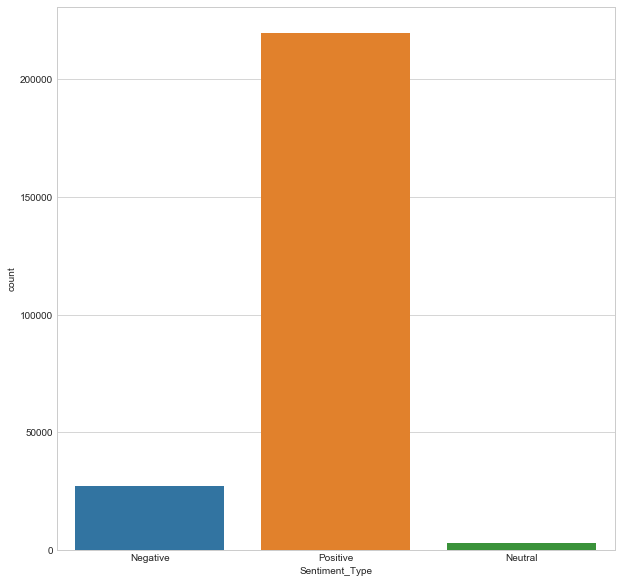

In [57]:
#Categorize the TextReview column into Positive, neutral and Negative sentiments using TextBlob
#Plot the Sentiment_Type
from textblob import TextBlob

bloblist_desc = list()

df_amazon=amazon['TextReview'].astype(str)
for row in df_amazon:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_amazon = pd.DataFrame(bloblist_desc, columns = ['sentence','sentiment','polarity'])
 
def f(df_amazon):
    if df_amazon['sentiment'] > 0:
        val = "Positive"
    elif df_amazon['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val

df_amazon['Sentiment_Type'] = df_amazon.apply(f, axis=1)

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=df_amazon)

In [58]:
df_amazon

,sentence,sentiment,polarity,Sentiment_Type
0,synopsis daily trek juarez mexico el paso texa...,-0.032917,0.472917,Negative
1,virgin juarez based true event surrounding cri...,0.003736,0.444828,Positive
2,scene film disquieting due graphic enactment r...,0.002549,0.557745,Positive
3,virgin juarez br directed kevin james dobson b...,0.027468,0.389858,Positive
4,informationally showtime original essential vi...,-0.013889,0.666667,Negative
5,murder juarez real movie badly acted fantasy r...,0.066667,0.522222,Positive
6,mexican men macho rapist gangster ineffective ...,-0.081250,0.320833,Negative
7,past year public television put series vintage...,0.157876,0.485648,Positive
8,recvd video dvd version christmas gift put pm ...,0.254386,0.465789,Positive
9,wow saw show pb great tune seeing group terrif...,0.195536,0.610714,Positive


In [59]:
#prediction
#Train/Test Split
x_train, x_test, y_train, y_test = train_test_split(df_amazon.sentence, df_amazon.Sentiment_Type, random_state=0)

In [60]:
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (187401,)
y_train shape: (187401,)

x_test shape: (62467,)
y_test shape: (62467,)



In [142]:
#CountVectorizer
# Vectorize X_train and X_test
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english').fit(x_train)
X_train = vectorizer.transform(x_train)
X_test = vectorizer.transform(x_test)
print("X_train:\n{}".format(repr(X_train)))
print("X_test:\n{}".format(repr(X_test)))

X_train:
<187401x85402 sparse matrix of type '<class 'numpy.int64'>'
	with 11146922 stored elements in Compressed Sparse Row format>
X_test:
<62467x85402 sparse matrix of type '<class 'numpy.int64'>'
	with 3687504 stored elements in Compressed Sparse Row format>


In [143]:
#GridSearchCV on training data
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [141]:
#Find best parameter from GridSearchCV and apply it in Logistic Regression classifier for best accuracy
print("Best cross-validation score: {:.3f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.910
Best parameters:  {'C': 1}


In [144]:
#Logistic Regression
#Mean cross-validation for Logistic Regression on Training data
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)
print("Mean cross-validation accuracy for Logistic Regression classifier : {:.3f}".format(np.mean(scores)))

Mean cross-validation accuracy for Logistic Regression classifier : 0.962


In [145]:
logreg = LogisticRegression(C=1).fit(X_train, y_train)
log_y_pred = logreg.predict(X_test)

In [146]:
logreg_score = accuracy_score(y_test, log_y_pred)
print("Logistic Regression Classifier Accuracy:   {:.3f}".format(logreg_score))

Logistic Regression Classifier Accuracy:   0.965


In [147]:
from sklearn.metrics import classification_report
print(classification_report(y_test, log_y_pred))

             precision    recall  f1-score   support

   Negative       0.89      0.84      0.87      6800
    Neutral       0.86      0.46      0.60       764
   Positive       0.97      0.99      0.98     54903

avg / total       0.96      0.96      0.96     62467



In [148]:
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 0.993
Test set score: 0.965


In [149]:
log_cfm = confusion_matrix(y_test, log_y_pred)
print("Confusion matrix:")
print(log_cfm, end='\n\n')

Confusion matrix:
[[ 5724    26  1050]
 [   36   355   373]
 [  674    32 54197]]



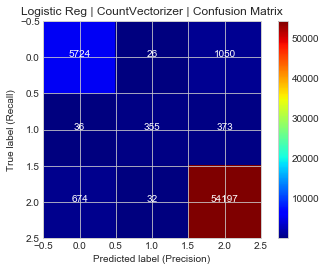

In [150]:
plt.imshow(log_cfm, interpolation='nearest',cmap=plt.cm.jet)

for i, j in itertools.product(range(log_cfm.shape[0]), range(log_cfm.shape[1])):
    plt.text(j, i, log_cfm[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Logistic Reg | CountVectorizer | Confusion Matrix')
plt.colorbar();

In [151]:
#Multinomial Bayes on Training data
#CountVectorizer
mnb = MultinomialNB(alpha=.01)
mnb.fit(X_train, y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [152]:
#Mean cross-validation for Multinomial Bayes on Training data
scores1 = cross_val_score(MultinomialNB(), X_train, y_train, cv=5)
print("Mean cross-validation accuracy for Multinomial Bayes classifier : {:.3f}".format(np.mean(scores1)))

Mean cross-validation accuracy for Multinomial Bayes classifier : 0.880


In [153]:
mnb_y_pred = mnb.predict(X_test)

In [154]:
mnb_score = accuracy_score(y_test, mnb_y_pred)
print("Multinomial Bayes Classifier Accuracy:   {:.3f}".format(mnb_score))

Multinomial Bayes Classifier Accuracy:   0.875


In [155]:
from sklearn.metrics import classification_report
print(classification_report(y_test, mnb_y_pred))

             precision    recall  f1-score   support

   Negative       0.50      0.59      0.54      6800
    Neutral       0.30      0.33      0.31       764
   Positive       0.94      0.92      0.93     54903

avg / total       0.88      0.87      0.88     62467



In [156]:
print("Training set score: {:.3f}".format(mnb.score(X_train, y_train)))
print("Test set score: {:.3f}".format(mnb.score(X_test, y_test)))

Training set score: 0.902
Test set score: 0.875


In [157]:
mnb_cfm = confusion_matrix(y_test, mnb_y_pred)
print("Confusion matrix:")
print(mnb_cfm, end='\n\n')

Confusion matrix:
[[ 4009   104  2687]
 [   43   251   470]
 [ 4040   487 50376]]



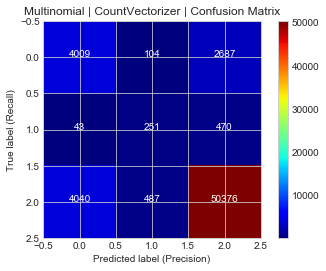

In [158]:
plt.imshow(mnb_cfm, interpolation='nearest',cmap=plt.cm.jet)

for i, j in itertools.product(range(mnb_cfm.shape[0]), range(mnb_cfm.shape[1])):
    plt.text(j, i, mnb_cfm[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Multinomial | CountVectorizer | Confusion Matrix')
plt.colorbar();

In [159]:
#Linear SVC
from sklearn.svm import LinearSVC
classifier_rbf = LinearSVC()
classifier_rbf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [160]:
#Mean cross-validation for SVC on Training data
scores2 = cross_val_score(LinearSVC(), X_train, y_train, cv=5)
print("Mean cross-validation accuracy for SVC classifier: {:.3f}".format(np.mean(scores2)))

Mean cross-validation accuracy for SVC classifier: 0.960


In [162]:
prediction_rbf = classifier_rbf.predict(X_test)

In [163]:
svc_score = accuracy_score(y_test, prediction_rbf)
print("SVC classifier Accuracy:   {:.3f}".format(svc_score))

SVC classifier Accuracy:   0.964


In [164]:
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction_rbf))

             precision    recall  f1-score   support

   Negative       0.86      0.85      0.86      6800
    Neutral       0.76      0.63      0.69       764
   Positive       0.98      0.98      0.98     54903

avg / total       0.96      0.96      0.96     62467



In [165]:
print("Training set score: {:.3f}".format(classifier_rbf.score(X_train, y_train)))
print("Test set score: {:.3f}".format(classifier_rbf.score(X_test, y_test)))

Training set score: 0.999
Test set score: 0.964


In [166]:
from sklearn.metrics import confusion_matrix
classifierSVC= confusion_matrix(y_test, prediction_rbf)
print("Confusion matrix:")
print(classifierSVC)

Confusion matrix:
[[ 5801    64   935]
 [   71   478   215]
 [  883    87 53933]]


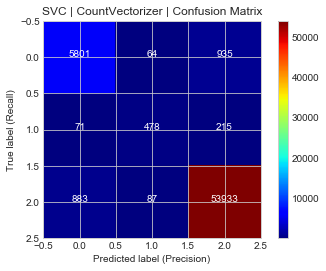

In [167]:
plt.imshow(classifierSVC, interpolation='nearest',cmap=plt.cm.jet)

for i, j in itertools.product(range(classifierSVC.shape[0]), range(classifierSVC.shape[1])):
    plt.text(j, i, classifierSVC[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('SVC | CountVectorizer | Confusion Matrix')
plt.colorbar();

In [168]:
#RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier()
classifier_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [169]:
#Mean cross-validation for RandomForest on Training data
scores3 = cross_val_score(RandomForestClassifier(), X_train, y_train, cv=5)
print("Mean cross-validation accuracy for RandomForest classifier: {:.3f}".format(np.mean(scores3)))

Mean cross-validation accuracy for RandomForest classifier: 0.913


In [170]:
rf_y_pred = classifier_rf.predict(X_test)

In [171]:
rf_score = accuracy_score(y_test, rf_y_pred )
print("RandomForestclassifier Accuracy:   {:.3f}".format(rf_score))

RandomForestclassifier Accuracy:   0.916


In [172]:
print(classification_report(y_test, rf_y_pred))

             precision    recall  f1-score   support

   Negative       0.86      0.36      0.51      6800
    Neutral       0.76      0.40      0.52       764
   Positive       0.92      0.99      0.95     54903

avg / total       0.91      0.92      0.90     62467



In [173]:
print("Training set score: {:.3f}".format(classifier_rf.score(X_train, y_train)))
print("Test set score: {:.3f}".format(classifier_rf.score(X_test, y_test)))

Training set score: 0.997
Test set score: 0.916


In [174]:
rf_cfm = confusion_matrix(y_test, rf_y_pred)
print("Confusion matrix:")
print(rf_cfm, end='\n\n')

Confusion matrix:
[[ 2440    25  4335]
 [   15   307   442]
 [  378    74 54451]]



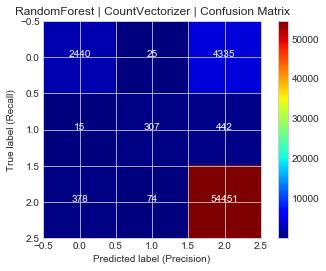

In [175]:
plt.imshow(rf_cfm, interpolation='nearest', cmap=plt.cm.jet)

for i, j in itertools.product(range(rf_cfm.shape[0]), range(rf_cfm.shape[1])):
    plt.text(j, i, rf_cfm[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('RandomForest | CountVectorizer | Confusion Matrix')
plt.colorbar();

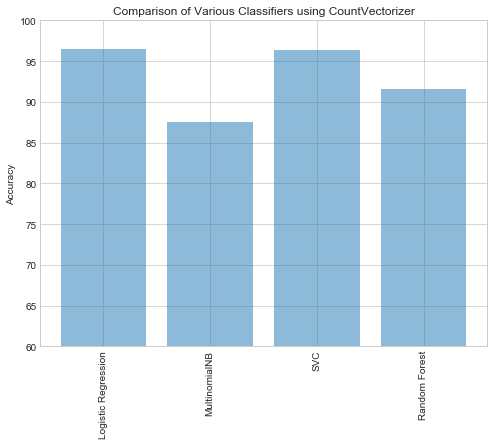

In [183]:
#Classifiers comparison
classifiers = ['Logistic Regression', 'MultinomialNB','SVC','Random Forest']
accuracies = [96.5, 87.5, 96.4, 91.6]
plt.figure(4, [8,6])
plt.bar(range(len(classifiers)), accuracies, align='center', alpha=0.5)
plt.xticks(range(len(classifiers)), classifiers, rotation=90)
plt.ylabel('Accuracy')
plt.title('Comparison of Various Classifiers using CountVectorizer')
plt.ylim([60, 100])
plt.show()

In [108]:
#TfidfVectorizer of x_train and x_test for all the following classifiers
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,stop_words='english').fit(x_train)
Tfidf_X_train = tfidf_vectorizer.transform(x_train)
Tfidf_X_test = tfidf_vectorizer.transform(x_test)
print("Tfidf_X_train:\n{}".format(repr(Tfidf_X_train)))
print("Tfidf_X_test:\n{}".format(repr(Tfidf_X_test)))

Tfidf_X_train:
<187401x85402 sparse matrix of type '<class 'numpy.float64'>'
	with 11146922 stored elements in Compressed Sparse Row format>
Tfidf_X_test:
<62467x85402 sparse matrix of type '<class 'numpy.float64'>'
	with 3687504 stored elements in Compressed Sparse Row format>


In [109]:
#Logistic Regression
#Mean cross-validation for Logistic Regression on Training data
tfidf_scores = cross_val_score(LogisticRegression(), Tfidf_X_train, y_train, cv=5)
print("Mean cross-validation accuracy for Logistic Regression classifier : {:.3f}".format(np.mean(tfidf_scores)))

Mean cross-validation accuracy for Logistic Regression classifier : 0.940


In [177]:
tfidf_logreg = LogisticRegression(C=1).fit(Tfidf_X_train, y_train)
tfidf_log_y_pred = tfidf_logreg.predict(Tfidf_X_test)

In [178]:
tfidf_logreg_score = accuracy_score(y_test, tfidf_log_y_pred)
print("Logistic Regression Classifier Accuracy:   {:.3f}".format(tfidf_logreg_score))

Logistic Regression Classifier Accuracy:   0.944


In [179]:
from sklearn.metrics import classification_report
print(classification_report(y_test, tfidf_log_y_pred))

             precision    recall  f1-score   support

   Negative       0.93      0.63      0.75      6800
    Neutral       0.83      0.09      0.17       764
   Positive       0.95      0.99      0.97     54903

avg / total       0.94      0.94      0.94     62467



In [180]:
tfidf_log_cfm = confusion_matrix(y_test, tfidf_log_y_pred)
print("Confusion matrix:")
print(tfidf_log_cfm, end='\n\n')

Confusion matrix:
[[ 4292     7  2501]
 [   21    70   673]
 [  289     7 54607]]



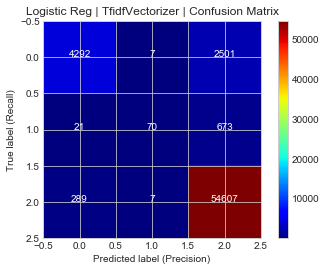

In [181]:
plt.imshow(tfidf_log_cfm, interpolation='nearest', cmap=plt.cm.jet)

for i, j in itertools.product(range(tfidf_log_cfm.shape[0]), range(tfidf_log_cfm.shape[1])):
    plt.text(j, i, tfidf_log_cfm[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Logistic Reg | TfidfVectorizer | Confusion Matrix')
plt.colorbar();

In [115]:
# Multinomial Bayes 
tfidf_mnb = MultinomialNB(alpha=.01)
tfidf_mnb.fit(Tfidf_X_train, y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [116]:
#Mean cross-validation for Multinomial Bayes on Training data
tfidf_scores1 = cross_val_score(MultinomialNB(), Tfidf_X_train, y_train, cv=5)
print("Mean cross-validation accuracy for Multinomial Bayes classifier : {:.3f}".format(np.mean(tfidf_scores1)))

Mean cross-validation accuracy for Multinomial Bayes classifier : 0.880


In [117]:
tfidf_mnb_y_pred = tfidf_mnb.predict(Tfidf_X_test)

In [118]:
tfidf_mnb_score = accuracy_score(y_test, tfidf_mnb_y_pred)
print("Multinomial Bayes Classifier Accuracy:   {:.3f}".format(tfidf_mnb_score))

Multinomial Bayes Classifier Accuracy:   0.892


In [119]:
from sklearn.metrics import classification_report
print(classification_report(y_test, tfidf_mnb_y_pred))

             precision    recall  f1-score   support

   Negative       0.84      0.14      0.23      6800
    Neutral       0.65      0.13      0.22       764
   Positive       0.89      1.00      0.94     54903

avg / total       0.88      0.89      0.86     62467



In [120]:
tfidf_mnb_cfm = confusion_matrix(y_test, tfidf_mnb_y_pred)
print("Confusion matrix:")
print(tfidf_mnb_cfm, end='\n\n')

Confusion matrix:
[[  927     9  5864]
 [    3   100   661]
 [  176    44 54683]]



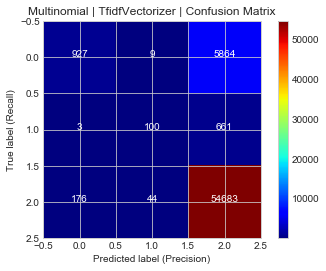

In [121]:
plt.imshow(tfidf_mnb_cfm, interpolation='nearest', cmap=plt.cm.jet)

for i, j in itertools.product(range(tfidf_mnb_cfm.shape[0]), range(tfidf_mnb_cfm.shape[1])):
    plt.text(j, i, tfidf_mnb_cfm[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Multinomial | TfidfVectorizer | Confusion Matrix')
plt.colorbar();

In [122]:
#Linear SVC
from sklearn.svm import LinearSVC
tfidf_classifier_rbf = LinearSVC()
tfidf_classifier_rbf.fit(Tfidf_X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [123]:
#Mean cross-validation for SVC on Training data
tfidf_scores2 = cross_val_score(LinearSVC(), Tfidf_X_train, y_train, cv=5)
print("Mean cross-validation accuracy for SVC classifier: {:.3f}".format(np.mean(tfidf_scores2)))

Mean cross-validation accuracy for SVC classifier: 0.960


In [126]:
tfidf_prediction_rbf = tfidf_classifier_rbf.predict(Tfidf_X_test)

In [127]:
tfidf_svc_score = accuracy_score(y_test, tfidf_prediction_rbf)
print("SVC classifier Accuracy:   {:.3f}".format(tfidf_svc_score))

SVC classifier Accuracy:   0.962


In [128]:
from sklearn.metrics import classification_report
print(classification_report(y_test, tfidf_prediction_rbf))

             precision    recall  f1-score   support

   Negative       0.89      0.81      0.85      6800
    Neutral       0.85      0.39      0.53       764
   Positive       0.97      0.99      0.98     54903

avg / total       0.96      0.96      0.96     62467



In [129]:
from sklearn.metrics import confusion_matrix
Tfidf_classifierSVC= confusion_matrix(y_test, tfidf_prediction_rbf)
print("Confusion matrix:")
print(Tfidf_classifierSVC)

Confusion matrix:
[[ 5511    22  1267]
 [   70   296   398]
 [  598    31 54274]]


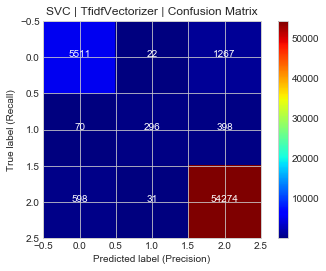

In [130]:
plt.imshow(Tfidf_classifierSVC, interpolation='nearest', cmap=plt.cm.jet)

for i, j in itertools.product(range(Tfidf_classifierSVC.shape[0]), range(Tfidf_classifierSVC.shape[1])):
    plt.text(j, i, Tfidf_classifierSVC[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('SVC | TfidfVectorizer | Confusion Matrix')
plt.colorbar();

In [131]:
#RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
tfidf_classifier_rf = RandomForestClassifier()
tfidf_classifier_rf.fit(Tfidf_X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [132]:
#Mean cross-validation for RandomForest on Training data
tfidf_scores3 = cross_val_score(RandomForestClassifier(), Tfidf_X_train, y_train, cv=5)
print("Mean cross-validation accuracy for RandomForest classifier: {:.3f}".format(np.mean(tfidf_scores3)))

Mean cross-validation accuracy for RandomForest classifier: 0.913


In [134]:
tfidf_rf_y_pred = tfidf_classifier_rf.predict(Tfidf_X_test)

In [135]:
tfidf_rf_score = accuracy_score(y_test, tfidf_rf_y_pred)
print("RandomForestclassifier Accuracy:   {:.3f}".format(tfidf_rf_score))

RandomForestclassifier Accuracy:   0.916


In [136]:
from sklearn.metrics import classification_report
print(classification_report(y_test, tfidf_rf_y_pred))

             precision    recall  f1-score   support

   Negative       0.88      0.35      0.50      6800
    Neutral       0.82      0.34      0.48       764
   Positive       0.92      0.99      0.95     54903

avg / total       0.91      0.92      0.90     62467



In [137]:
tfidf_rf_cfm = confusion_matrix(y_test, tfidf_rf_y_pred)
print("Confusion matrix:")
print(tfidf_rf_cfm, end='\n\n')

Confusion matrix:
[[ 2365    16  4419]
 [   23   261   480]
 [  288    41 54574]]



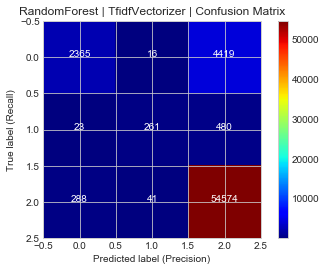

In [138]:
plt.imshow(tfidf_rf_cfm, interpolation='nearest', cmap=plt.cm.jet)

for i, j in itertools.product(range(tfidf_rf_cfm.shape[0]), range(tfidf_rf_cfm.shape[1])):
    plt.text(j, i, tfidf_rf_cfm[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('RandomForest | TfidfVectorizer | Confusion Matrix')
plt.colorbar();

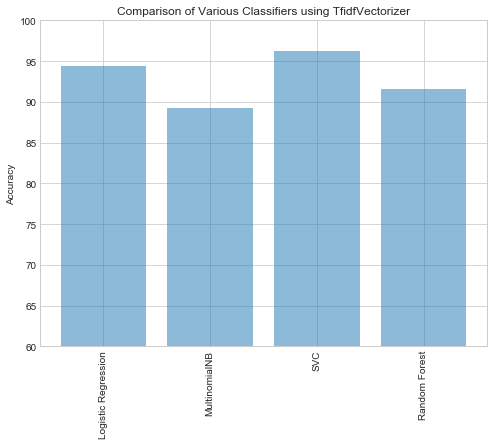

In [182]:
#Classifiers comparison using TfidfVectorizer
Tfidf_classifiers = ['Logistic Regression', 'MultinomialNB','SVC','Random Forest']
accuracies = [94.4, 89.2, 96.2, 91.6]
plt.figure(4, [8,6])
plt.bar(range(len(Tfidf_classifiers)), accuracies, align='center', alpha=0.5)
plt.xticks(range(len(Tfidf_classifiers)), Tfidf_classifiers, rotation=90)
plt.ylabel('Accuracy')
plt.title('Comparison of Various Classifiers using TfidfVectorizer')
plt.ylim([60, 100])
plt.show()